In [4]:
The Ramsey/Cass-Koopmans Model

Many economic and financial models, such as those for resource allocation or optimal growth, involve systems of differential equations with no explicit analytical solution. Solving these systems numerically and visualizing results are important tasks for economists and other financial analysts.


In [ ]:
from numba import njit 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
# first we formulate the utility function 
def u(c, γ):
    '''
    Utility function
    ASIDE: If you have a utility function that is hard to solve by hand
    you can use automatic or symbolic  differentiation
    See https://github.com/HIPS/autograd
    '''
    if γ == 1:
        # If γ = 1 we can show via L'hopital's Rule that the utility
        # becomes log
        return np.log(c)
    else:
        return c**(1 - γ) / (1 - γ)

@njit
def u_prime(c, γ):
    '''Derivative of utility'''
    if γ == 1:
        return 1 / c
    else:
        return c**(-γ)

@njit
def u_prime_inv(c, γ):
    '''Inverse utility'''
    if γ == 1:
        return c
    else:
        return c**(-1 / γ)

@njit
def f(A, k, α):
    '''Production function'''
    return A * k**α

@njit
def f_prime(A, k, α):
    '''Derivative of production function'''
    return α * A * k**(α - 1)

@njit
def f_prime_inv(A, k, α):
    return (k / (A * α))**(1 / (α - 1))



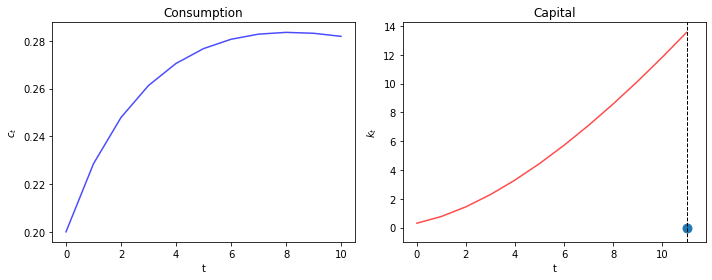

In [6]:
# Parameters
γ = 2
δ = 0.02
β = 0.95
α = 0.33
A = 1

# Initial guesses
T = 10
c = np.zeros(T+1)  # T periods of consumption initialized to 0
# T periods of capital initialized to 0 (T+2 to include t+1 variable as well)
k = np.zeros(T+2)
k[0] = 0.3  # Initial k
c[0] = 0.2  # Guess of c_0

@njit
def shooting_method(c, # Initial consumption
                    k,   # Initial capital
                    γ,   # Coefficient of relative risk aversion
                    δ,   # Depreciation rate on capital# Depreciation rate
                    β,   # Discount factor
                    α,   # Return to capital per capita
                    A):  # Technology

    T = len(c) - 1

    for t in range(T):
        # Equation 1 with inequality
        k[t+1] = f(A=A, k=k[t], α=α) + (1 - δ) * k[t] - c[t]
        if k[t+1] < 0:   # Ensure nonnegativity
            k[t+1] = 0

      # Equation 2: We keep in the general form to show how we would
      # solve if we didn't want to do any simplification

        if β * (f_prime(A=A, k=k[t+1], α=α) + (1 - δ)) == np.inf:
            # This only occurs if k[t+1] is 0, in which case, we won't
            # produce anything next period, so consumption will have to be 0
            c[t+1] = 0
        else:
            c[t+1] = u_prime_inv(u_prime(c=c[t], γ=γ) \
            / (β * (f_prime(A=A, k=k[t+1], α=α) + (1 - δ))), γ=γ)

    # Terminal condition calculation
    k[T+1] = f(A=A, k=k[T], α=α) + (1 - δ) * k[T] - c[T]

    return c, k

paths = shooting_method(c, k, γ, δ, β, α, A)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

for path, color, title, y, ax in zip(paths, colors, titles, ylabels, axes):
    ax.plot(path, c=color, alpha=0.7)
    ax.set(title=title, ylabel=y, xlabel='t')

ax.scatter(T+1, 0, s=80)
ax.axvline(T+1, color='k', ls='--', lw=1)

plt.tight_layout()
plt.show()

In [7]:
@njit
def bisection_method(c,
                     k,
                     γ,              # Coefficient of relative risk aversion
                     δ,              # Depreciation rate
                     β,              # Discount factor
                     α,              # Return to capital per capita
                     A,              # Technology
                     tol=1e-4,
                     max_iter=1e4,
                     terminal=0):    # Value we are shooting towards

    T = len(c) - 1
    i = 1                            # Initial iteration
    c_high = f(k=k[0], α=α, A=A)     # Initial high value of c
    c_low = 0                        # Initial low value of c

    path_c, path_k = shooting_method(c, k, γ, δ, β, α, A)

    while (np.abs((path_k[T+1] - terminal)) > tol or path_k[T] == terminal) \
        and i < max_iter:

        if path_k[T+1] - terminal > tol:
            # If assets are too high the c[0] we chose is now a lower bound
            # on possible values of c[0]
            c_low = c[0]
        elif path_k[T+1] - terminal < -tol:
            # If assets fell too quickly, the c[0] we chose is now an upper
            # bound on possible values of c[0]
            c_high=c[0]
        elif path_k[T] == terminal:
            # If assets fell  too quickly, the c[0] we chose is now an upper
            # bound on possible values of c[0]
            c_high=c[0]

        c[0] = (c_high + c_low) / 2  # This is the bisection part
        path_c, path_k = shooting_method(c, k, γ, δ, β, α, A)
        i += 1

    if np.abs(path_k[T+1] - terminal) < tol and path_k[T] != terminal:
        print('Converged successfully on iteration', i-1)
    else:
        print('Failed to converge and hit maximum iteration')

    μ = u_prime(c=path_c, γ=γ)
    return path_c, path_k, μ

Converged successfully on iteration 18


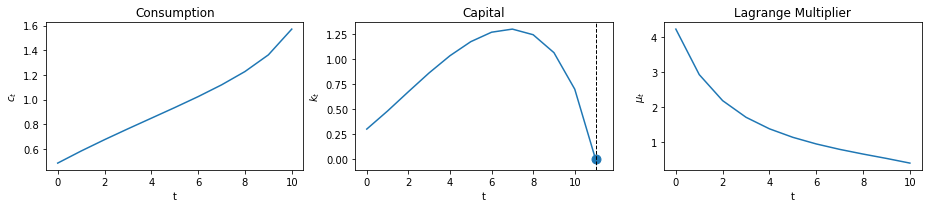

In [8]:
T = 10
c = np.zeros(T+1) # T periods of consumption initialized to 0
# T periods of capital initialized to 0. T+2 to include t+1 variable as well
k = np.zeros(T+2)

k[0] = 0.3 # initial k
c[0] = 0.3 # our guess of c_0

paths = bisection_method(c, k, γ, δ, β, α, A)

def plot_paths(paths, axes=None, ss=None):

    T = len(paths[0])

    if axes is None:
        fix, axes = plt.subplots(1, 3, figsize=(13, 3))

    ylabels = ['$c_t$', '$k_t$', '$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    for path, y, title, ax in zip(paths, ylabels, titles, axes):
        ax.plot(path)
        ax.set(ylabel=y, title=title, xlabel='t')

    # Plot steady state value of capital
    if ss is not None:
        axes[1].axhline(ss, c='k', ls='--', lw=1)

    axes[1].axvline(T, c='k', ls='--', lw=1)
    axes[1].scatter(T, paths[1][-1], s=80)
    plt.tight_layout()

plot_paths(paths)

In [9]:
ρ = 1 / β - 1
k_ss = f_prime_inv(k=ρ+δ, A=A, α=α)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 9.57583816331462


Converged successfully on iteration 39


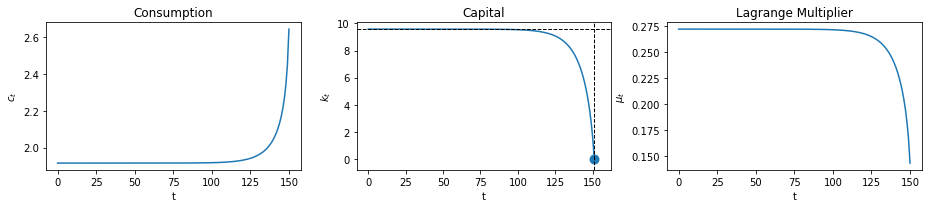

In [10]:
T = 150
c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_ss  # Start at steady state
paths = bisection_method(c, k, γ, δ, β, α, A)

plot_paths(paths, ss=k_ss)

Converged successfully on iteration 39


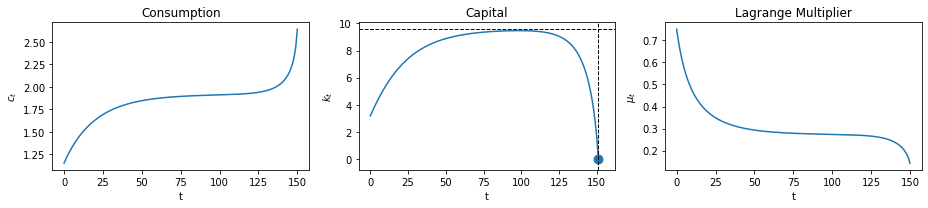

In [11]:
k_init = k_ss / 3   # Below our steady state
T = 150
c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_init
paths = bisection_method(c, k, γ, δ, β, α, A)

plot_paths(paths, ss=k_ss)

Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25
Converged successfully on iteration 22


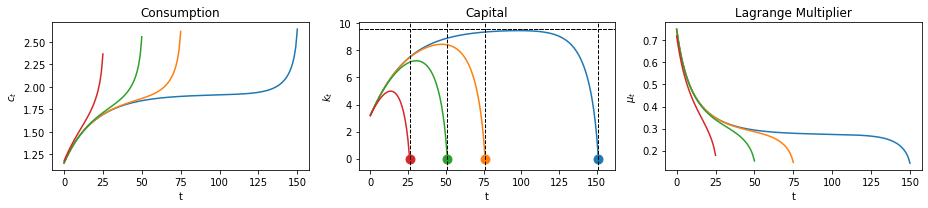

In [12]:
T_list = (150, 75, 50, 25)

fix, axes = plt.subplots(1, 3, figsize=(13, 3))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_init
    paths = bisection_method(c, k, γ, δ, β, α, A)
    plot_paths(paths, ss=k_ss, axes=axes)